In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)

train_image_dir = './train'

name_label_dict = {
0:  "Nucleoplasm", 
1:  "Nuclear membrane",   
2:  "Nucleoli",   
3:  "Nucleoli fibrillar center" ,  
4:  "Nuclear speckles"   ,
5:  "Nuclear bodies"   ,
6:  "Endoplasmic reticulum",   
7:  "Golgi apparatus"   ,
8:  "Peroxisomes"   ,
9:  "Endosomes"   ,
10:  "Lysosomes"   ,
11:  "Intermediate filaments",   
12:  "Actin filaments"   ,
13:  "Focal adhesion sites",   
14:  "Microtubules"   ,
15:  "Microtubule ends",   
16:  "Cytokinetic bridge",   
17:  "Mitotic spindle"   ,
18:  "Microtubule organizing center" ,  
19:  "Centrosome"   ,
20:  "Lipid droplets",   
21:  "Plasma membrane",   
22:  "Cell junctions"  , 
23:  "Mitochondria"   ,
24:  "Aggresome"   ,
25:  "Cytosol",
26:  "Cytoplasmic bodies",   
27:  "Rods & rings" 
}

In [2]:
image_df = pd.read_csv(os.path.join('./',
                                 'train.csv'))
print(image_df.shape[0], 'masks found')
print(image_df['Id'].value_counts().shape[0])
# just use green for now
image_df['path'] = image_df['Id'].map(lambda x: os.path.join(train_image_dir, '{}.rgb'.format(x)))
image_df['target_list'] = image_df['Target'].map(lambda x: [int(a) for a in x.split(' ')])
image_df.head()

31072 masks found
31072


,Id,Target,path,target_list
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0,./train/00070df0-bbc3-11e8-b2bc-ac1f6b6435d0.rgb,"[16, 0]"
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0,./train/000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0.rgb,"[7, 1, 2, 0]"
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5,./train/000a9596-bbc4-11e8-b2bc-ac1f6b6435d0.rgb,[5]
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1,./train/000c99ba-bba4-11e8-b2b9-ac1f6b6435d0.rgb,[1]
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18,./train/001838f8-bbca-11e8-b2bc-ac1f6b6435d0.rgb,[18]


Nucleoplasm count: 12885
Nuclear membrane count: 1254
Nucleoli count: 3621
Nucleoli fibrillar center count: 1561
Nuclear speckles count: 1858
Nuclear bodies count: 2513
Endoplasmic reticulum count: 1008
Golgi apparatus count: 2822
Peroxisomes count: 53
Endosomes count: 45
Lysosomes count: 28
Intermediate filaments count: 1093
Actin filaments count: 688
Focal adhesion sites count: 537
Microtubules count: 1066
Microtubule ends count: 21
Cytokinetic bridge count: 530
Mitotic spindle count: 210
Microtubule organizing center count: 902
Centrosome count: 1482
Lipid droplets count: 172
Plasma membrane count: 3777
Cell junctions count: 802
Mitochondria count: 2965
Aggresome count: 322
Cytosol count: 8228
Cytoplasmic bodies count: 328
Rods & rings count: 11


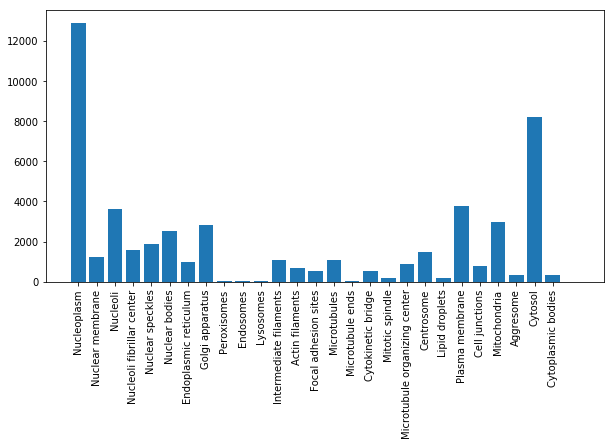

In [5]:
from itertools import chain
from collections import Counter
all_labels = list(chain.from_iterable(image_df['target_list'].values))
c_val = Counter(all_labels)
n_keys = c_val.keys()
max_idx = max(n_keys)
fig, ax1 = plt.subplots(1,1, figsize = (10, 5))
ax1.bar(n_keys, [c_val[k] for k in n_keys])
ax1.set_xticks(range(max_idx))
ax1.set_xticklabels([name_label_dict[k] for k in range(max_idx)], rotation=90)
for k,v in c_val.items():
    print(name_label_dict[k], 'count:', v)

In [6]:
image_df['target_vec'] = image_df['target_list'].map(lambda ck: [i in ck for i in range(max_idx+1)])
image_df.sample(3)

,Id,Target,path,target_list,target_vec
7256,3c298b58-bbb6-11e8-b2ba-ac1f6b6435d0,19 16 0,./train/3c298b58-bbb6-11e8-b2ba-ac1f6b6435d0.rgb,"[19, 16, 0]","[True, False, False, False, False, False, Fals..."
857,076cb480-bba2-11e8-b2b9-ac1f6b6435d0,0 21,./train/076cb480-bba2-11e8-b2b9-ac1f6b6435d0.rgb,"[0, 21]","[True, False, False, False, False, False, Fals..."
20476,a8faf21a-bbb8-11e8-b2ba-ac1f6b6435d0,0,./train/a8faf21a-bbb8-11e8-b2ba-ac1f6b6435d0.rgb,[0],"[True, False, False, False, False, False, Fals..."


# training set 과 validation set으로 나누기

라벨별 비율 맞추기

In [7]:
from sklearn.model_selection import train_test_split
raw_train_df, valid_df = train_test_split(image_df, 
                 test_size = 0.3, 
                  # hack to make stratification work                  
                 stratify = image_df['Target'].map(lambda x: x[:3] if '27' not in x else '0'))
print(raw_train_df.shape[0], 'training masks')
print(valid_df.shape[0], 'validation masks')

21750 training masks
9322 validation masks


In [9]:
TRAIN_IMAGES_PER_CATEGORY = 500 

# keep labels with more then 50 objects
out_df_list = []
for k,v in c_val.items():
    if v>100:
        keep_rows = raw_train_df['target_list'].map(lambda x: k in x)
        out_df_list += [raw_train_df[keep_rows].sample(TRAIN_IMAGES_PER_CATEGORY, 
                                                       replace=True)]
train_df = pd.concat(out_df_list, ignore_index=True)
print(train_df.shape[0])
train_df.sample(3)

11500


,Id,Target,path,target_list,target_vec
4566,8bed2d1e-bbc7-11e8-b2bc-ac1f6b6435d0,12,./train/8bed2d1e-bbc7-11e8-b2bc-ac1f6b6435d0.rgb,[12],"[False, False, False, False, False, False, Fal..."
4866,2249965e-bba4-11e8-b2b9-ac1f6b6435d0,12,./train/2249965e-bba4-11e8-b2b9-ac1f6b6435d0.rgb,[12],"[False, False, False, False, False, False, Fal..."
995,b7a108aa-bbad-11e8-b2ba-ac1f6b6435d0,1 0,./train/b7a108aa-bbad-11e8-b2ba-ac1f6b6435d0.rgb,"[1, 0]","[True, True, False, False, False, False, False..."


Text(0.5,1,'Validation Distribution')

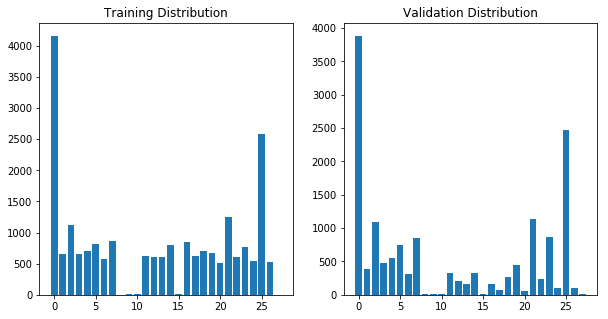

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
train_sum_vec = np.sum(np.stack(train_df['target_vec'].values, 0), 0)
valid_sum_vec = np.sum(np.stack(valid_df['target_vec'].values, 0), 0)
ax1.bar(n_keys, [train_sum_vec[k] for k in n_keys])
ax1.set_title('Training Distribution')
ax2.bar(n_keys, [valid_sum_vec[k] for k in n_keys])
ax2.set_title('Validation Distribution')

In [15]:
raw_train_df.head()

,Id,Target,path,target_list,target_vec
28317,e93e66e4-bbb4-11e8-b2ba-ac1f6b6435d0,23 0,./train/e93e66e4-bbb4-11e8-b2ba-ac1f6b6435d0.rgb,"[23, 0]","[True, False, False, False, False, False, Fals..."
29255,f0e35860-bba4-11e8-b2ba-ac1f6b6435d0,18,./train/f0e35860-bba4-11e8-b2ba-ac1f6b6435d0.rgb,[18],"[False, False, False, False, False, False, Fal..."
23255,bfbb3a40-bb9b-11e8-b2b9-ac1f6b6435d0,25 0,./train/bfbb3a40-bb9b-11e8-b2b9-ac1f6b6435d0.rgb,"[25, 0]","[True, False, False, False, False, False, Fals..."
3726,1f176592-bbb8-11e8-b2ba-ac1f6b6435d0,5,./train/1f176592-bbb8-11e8-b2ba-ac1f6b6435d0.rgb,[5],"[False, False, False, False, False, True, Fals..."
11235,5d50ea4c-bbb6-11e8-b2ba-ac1f6b6435d0,12 0,./train/5d50ea4c-bbb6-11e8-b2ba-ac1f6b6435d0.rgb,"[12, 0]","[True, False, False, False, False, False, Fals..."


In [16]:
valid_df.head()

,Id,Target,path,target_list,target_vec
18238,96eb4174-bbae-11e8-b2ba-ac1f6b6435d0,25 3,./train/96eb4174-bbae-11e8-b2ba-ac1f6b6435d0.rgb,"[25, 3]","[False, False, False, True, False, False, Fals..."
12778,6a1b9e80-bbab-11e8-b2ba-ac1f6b6435d0,25,./train/6a1b9e80-bbab-11e8-b2ba-ac1f6b6435d0.rgb,[25],"[False, False, False, False, False, False, Fal..."
28835,ed865da2-bbb3-11e8-b2ba-ac1f6b6435d0,25 3,./train/ed865da2-bbb3-11e8-b2ba-ac1f6b6435d0.rgb,"[25, 3]","[False, False, False, True, False, False, Fals..."
2341,136d90b6-bbab-11e8-b2ba-ac1f6b6435d0,0,./train/136d90b6-bbab-11e8-b2ba-ac1f6b6435d0.rgb,[0],"[True, False, False, False, False, False, Fals..."
1287,0ac10984-bbba-11e8-b2ba-ac1f6b6435d0,2 0,./train/0ac10984-bbba-11e8-b2ba-ac1f6b6435d0.rgb,"[2, 0]","[True, False, True, False, False, False, False..."


In [12]:
raw_train_df.to_csv("train_set.csv", mode='w')

In [17]:
valid_df.to_csv("validation_set.csv", mode='w')